# Which population is at greatest risk for suicide?

### Datasets used in this kernel:
* [Suicide rates](https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016) from 1985 to 2016 (based on year, country, age group)
* [ISO alpha-3 (three-letter) country codes](https://www.kaggle.com/taniaj/world-bank-country-and-lending-groups)
* GNI per capita and income group classification from World Bank
* [Region (e.g., South Asia, Europe) information](https://www.kaggle.com/taniaj/world-bank-country-and-lending-groups) for countries

### Note to myself: New methods/functions I used

* **merge** (similar to vlookup in Excel; with merge, for-loop becomes unnecessary; more info: https://www.geeksforgeeks.org/how-to-do-a-vlookup-in-python-using-pandas/)
* **apply** (map() function works on Series only. Use apply() instead; more info:  https://kanoki.org/2019/11/25/pandas-apply-map-and-applymap/)
* **cut** (use it to bin data into categories; more info: https://pbpython.com/pandas-qcut-cut.html)
* **ttest** 
* **Plots:** 
> * Choropleth map (plotly.express > folium; Plotly.express has a built-in country geometry (with three-letter ISO country codes), whereas folium asks you to upload the country geojson file; more info: https://plotly.com/python/choropleth-maps/)
> * stripplot ("hue=category" works here as well to color the dots based on the category) 
> * lineplot with groupby (You don't need to create separate dataframes for different categories for the line plot)

In [1]:
# Load necessary libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# In order to have the output of plotting function printed to the notebook
%matplotlib inline 

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/world-bank-country-and-lending-groups/worldbank_classification.csv
/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv
/kaggle/input/worldincomegroupclassification/GNI per capita.csv
/kaggle/input/worldincomegroupclassification/income classification threshold.csv


In [2]:
main_df=pd.read_csv("/kaggle/input/suicide-rates-overview-1985-to-2016/master.csv")
main_df.head(10)

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
5,Albania,1987,female,75+ years,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
6,Albania,1987,female,35-54 years,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,Silent
7,Albania,1987,female,25-34 years,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,Boomers
8,Albania,1987,male,55-74 years,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
9,Albania,1987,female,5-14 years,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,Generation X


In [3]:
# Create a summary table for the dataframe

def summary_df(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    
    return summary

In [4]:
summary_df(main_df)

Dataset Shape: (27820, 12)


,Name,dtypes,Missing,Uniques
0,country,object,0,101
1,year,int64,0,32
2,sex,object,0,2
3,age,object,0,6
4,suicides_no,int64,0,2084
5,population,int64,0,25564
6,suicides/100k pop,float64,0,5298
7,country-year,object,0,2321
8,HDI for year,float64,19456,305
9,gdp_for_year ($),object,0,2321


> * **No missing values** for the information I need for analysis. GREAT! 
> * The "HDI for year" column won't be used in this kernel.

## Prepare the dataset for analysis

### Checking the distribution of data points over time

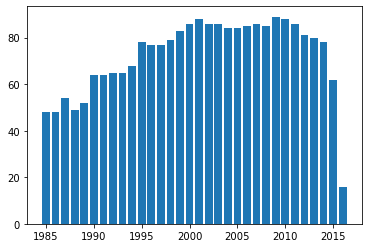

In [5]:
# How many countries were survayed each year?
year_df=main_df.groupby("year").agg({"country":"nunique"}).reset_index()
fig=plt.figure()
plt.bar(year_df["year"], year_df["country"])
plt.show()

> Unfortunately, we don't have the same number of countries examined for each year. Let's limit our analysis to years that surveyed more than 60 countires--**from 1990 to 2015**.

In [6]:
# Find the index of the first row of 1990 data
main_df=main_df.sort_values(by=["year"]).reset_index(drop=True)
idx_list_1990=main_df[main_df["year"]==1990].index.values.tolist()
start_year=min(idx_list_1990)

# Find the index of the last row of 2015 data
idx_list_2015=main_df[main_df["year"]==2015].index.values.tolist()
end_year=max(idx_list_2015)

# Slice the Dataframe so that we have only 1990-2005 data
main_df=main_df.iloc[start_year:end_year].reset_index(drop=True)

In [7]:
# After selecting the 1990-2005 rows out of the original dataset
main_df

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Australia,1990,female,5-14 years,0,1215500,0.00,Australia1990,0.865,"310,838,014,621",19665,Generation X
1,Argentina,1990,female,75+ years,61,643000,9.49,Argentina1990,0.705,"141,352,368,715",4859,G.I. Generation
2,Argentina,1990,male,25-34 years,182,2297000,7.92,Argentina1990,0.705,"141,352,368,715",4859,Boomers
3,Australia,1990,female,15-24 years,64,1354800,4.72,Australia1990,0.865,"310,838,014,621",19665,Generation X
4,Argentina,1990,female,55-74 years,190,2477000,7.67,Argentina1990,0.705,"141,352,368,715",4859,G.I. Generation
...,...,...,...,...,...,...,...,...,...,...,...,...
24642,Ecuador,2015,male,5-14 years,35,1569519,2.23,Ecuador2015,NaN,"99,290,381,000",6832,Generation Z
24643,Ecuador,2015,female,55-74 years,22,932718,2.36,Ecuador2015,NaN,"99,290,381,000",6832,Boomers
24644,Ecuador,2015,female,35-54 years,46,1876229,2.45,Ecuador2015,NaN,"99,290,381,000",6832,Generation X
24645,Ecuador,2015,female,25-34 years,56,1283175,4.36,Ecuador2015,NaN,"99,290,381,000",6832,Millenials


### Making country names consistent between dataframes
* Sometimes, different dataframe use different names for the same contry (USA vs. United States vs. United States of America).
* This impedes merging different dataframe based on the country name.
* Solution: Use the ISO alpha-3 country code (e.g., ALB for Albania, CAN for Canada) instead of the country name.

In [8]:
# Create a DataFrame that has country name, country code, region, and income group information
class_df=pd.read_csv("/kaggle/input/world-bank-country-and-lending-groups/worldbank_classification.csv")
class_df

,x,Economy,Code,Region,Income group,Lending category,Other
0,1,Afghanistan,AFG,South Asia,Low income,IDA,HIPC
1,2,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,NaN
2,3,Algeria,DZA,Middle East & North Africa,Upper middle income,IBRD,NaN
3,4,American Samoa,ASM,East Asia & Pacific,Upper middle income,NaN,NaN
4,5,Andorra,AND,Europe & Central Asia,High income,NaN,NaN
...,...,...,...,...,...,...,...
213,214,Virgin Islands (U.S.),VIR,Latin America & Caribbean,High income,NaN,NaN
214,215,West Bank and Gaza,PSE,Middle East & North Africa,Lower middle income,NaN,NaN
215,216,Yemen,YEM,Middle East & North Africa,Low income,IDA,NaN
216,217,Zambia,ZMB,Sub-Saharan Africa,Lower middle income,IDA,HIPC


In [9]:
# Clean the class_df for future use
class_df=class_df.drop(columns=["x","Lending category","Other"])
class_df=class_df.rename(columns={"Economy": "country","Code":"country code"})
countries_218=class_df["country"].tolist()
class_df=class_df.set_index("country")

In [10]:
# Identify which country names are different between main_df and class_df
main_countries=main_df["country"].unique().tolist()

print("The names of the following countries are different between two dataframes:")
for country in main_countries:
    if country in countries_218:
        continue
    else:
        print (country)

The names of the following countries are different between two dataframes:
Russian Federation
Republic of Korea
Saint Vincent and Grenadines
Kyrgyzstan
Saint Lucia
Saint Kitts and Nevis
Slovakia
Macau


In [11]:
# Make the country names consistent between main_df and class_df
main_df['country'] = main_df['country'].replace("Kyrgyzstan","Kyrgyz Republic")
main_df['country'] = main_df['country'].replace("Macau", "Macao SAR")
main_df['country'] = main_df['country'].replace("Republic of Korea", "South Korea")
main_df['country'] = main_df['country'].replace("Russian Federation", "Russia")
main_df['country'] = main_df['country'].replace("Saint Kitts and Nevis", "St. Kitts and Nevis")
main_df['country'] = main_df['country'].replace("Saint Lucia", "St. Lucia")
main_df['country'] = main_df['country'].replace("Saint Vincent and Grenadines", "St. Vincent and the Grenadines")
main_df['country'] = main_df['country'].replace("Slovakia", "Slovak Republic")

> Now, the country names are consistent bewteen dataframes we are going to use for analysis.

# EDA: Worldwide suicide rate (per 100,000 population)

## Functions

In [12]:
# Grab the category information (e.g., Region, ISO code) from the class_df and add it to the new dataframe
def add_classification(df, classification):
    
    group_labels=class_df[classification]
    left_join=pd.merge(df, group_labels, on="country", how='left') 
    
    return left_join

In [13]:
# Create the suicide rate (per 100,000 population) column
def groupby_add_s_rate(df, groupby):
    new_df=df.groupby(groupby).agg({"suicides_no":"sum", "population":"sum"}).reset_index()
    new_df["suicides/100k pop"]=new_df["suicides_no"]/new_df["population"]*100000
    return new_df

In [14]:
# Create a Choropleth Map for a given year
import plotly.express as px

def world_map_year (year):
    new_df=main_df[main_df["year"]==year]
    new_df=new_df.groupby("country").agg({"suicides_no":"sum", "population":"sum"}).reset_index()
    new_df["suicides/100k pop"] = new_df["suicides_no"]/new_df["population"]*100000
    
    # Add ISO alpha3 country code to dataframe
    df_w_code=add_classification(new_df, "country code")
    
    fig = px.choropleth(df_w_code, 
                    locations="country code",
                    color="suicides/100k pop", 
                    hover_name="country", # column to add to hover information
                    color_continuous_scale=px.colors.sequential.Plasma)
    title = 'Suicide rate (per 100,000 population) in {}'.format(year)
    fig.update_layout(title_text=title)
    fig.show()

In [15]:
def world_map_slider(df, column, map_title):

    # Define the max and min of the color bar
    bar_max=df[column].max()
    bar_min=df[column].min()
    
    # Add ISO alpha3 country code to dataframe
    df_w_code=add_classification(df, "country code")
    
    # Make a choropleth map
    fig = px.choropleth(df_w_code, locations="country code",
                    color=column,
                    hover_name="country",
                    animation_frame="year",
                    title = map_title,
                    range_color=(bar_min, bar_max),   # Without setting this up, the color bar range changes
                   color_continuous_scale=px.colors.sequential.Plasma)
    #fig["layout"].pop("updatemenus")  # Uncomment it if you want to manually drag the slider
    fig.show()

## A Choropleth map of a single year

In [16]:
world_map_year(2009)

## A Choropleth map with slider

In [17]:
# Groupby year and country
year_country_df=groupby_add_s_rate(main_df, ["year","country"])

# Make a world map with slider
world_map_slider(year_country_df, "suicides/100k pop", "Suicide rate (per 100,000 population) from 1990 to 2015")

> Choropleth maps look cool. However, it is **hard to see small countries** and any changes occuring in them. Remember this caveat when using choropleth maps for data visualization. 

## Suicide rate plot

Text(0.5, 0.98, 'Worldwide suicide rate from 1990 to 2015, both sexes')

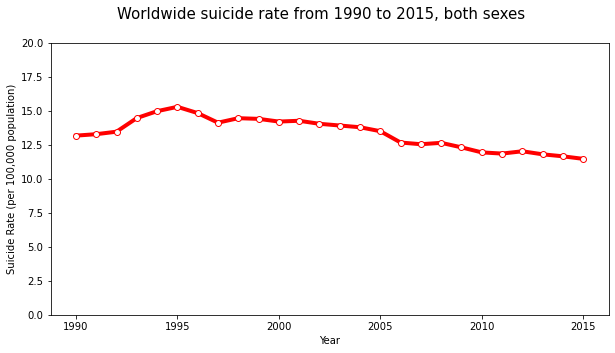

In [18]:
# Total suicide rate over time
s_rate_year=groupby_add_s_rate(main_df, ["year"])

# Plot a graph
fig=plt.figure(figsize=(10,5))
plt.plot( "year", "suicides/100k pop", data=s_rate_year, marker='o', 
         markerfacecolor='white', markersize=6, color='red', linewidth=4)
plt.xlabel("Year")
plt.ylim(0,20)
plt.ylabel("Suicide Rate (per 100,000 population)")
fig.suptitle("Worldwide suicide rate from 1990 to 2015, both sexes", fontsize=15)

> * The global suicide rate has been between 12.5 and 15.5 per 100,000 population. 
> * The rate has been slowly decreasing from early 2000.
> * From 1992 to 1995, the global suicide rate went up. I wonder whether the early 1990s economic downturn was one of the reasons.


# Visualization of the country-specific suicide rate

In [19]:
import seaborn as sns

all_countries_year=groupby_add_s_rate(main_df, ["year","country"])

def country_stat (country):   
    # Extract the country specific data 
    country_df=main_df[main_df["country"]==country]
    
    # Create a plot 
    fig, axes = plt.subplots(3, figsize=(15,10))
    fig.text(0.08, 0.5, 'Suicide rate (per 100,000 population)', va='center', rotation='vertical')

    # Give some space between subplots
    plt.subplots_adjust(hspace=0.4)
    
    # Top plot: Box plot
    sns.boxplot(y=all_countries_year['suicides/100k pop'], x=all_countries_year['year'], palette="YlGn", ax=axes[0])

    # Top plot: line plot (both sexes). IMPORTANT: Change the x values to STRING b/c sns.boxplot convert x.dtype to string.
    suicide_df=groupby_add_s_rate(country_df, "year")
    sns.lineplot(y=suicide_df['suicides/100k pop'], x=suicide_df['year'].astype('str'), 
                 color='red', linewidth=2.5, ax=axes[0])
    axes[0].set(ylabel=None)
    axes[0].set(xlabel=None)
    axes[0].set_title("Box plot: all countries; line plot: {}".format(country))
 
    # Middle plot: line plot (male vs. female)
    mf_df=groupby_add_s_rate(country_df, ["year", "sex"])
 
    for key, grp in mf_df.groupby(['sex']):
        axes[1].plot(grp["year"], grp["suicides/100k pop"], label=key)
    ymax=max(mf_df["suicides/100k pop"])+4
    axes[1].set_ylim([0,ymax])
    axes[1].legend(loc="best")
    axes[1].set_title("Male vs. Female Suicide Rates of {}".format(country))

    # Bottom plot: line plot (age groups)
    age_df=groupby_add_s_rate(country_df, ["year", "age"])

    for key, grp in age_df.groupby(['age']):
        axes[2].plot(grp["year"], grp["suicides/100k pop"], label=key)

    ymax2=max(age_df["suicides/100k pop"])+4
    axes[2].set_ylim([0,ymax2])
    axes[2].set_xlabel("year")
    axes[2].legend(loc="best")
    axes[2].set_title("Suicide Rates of Different Age Groups in {}".format(country))

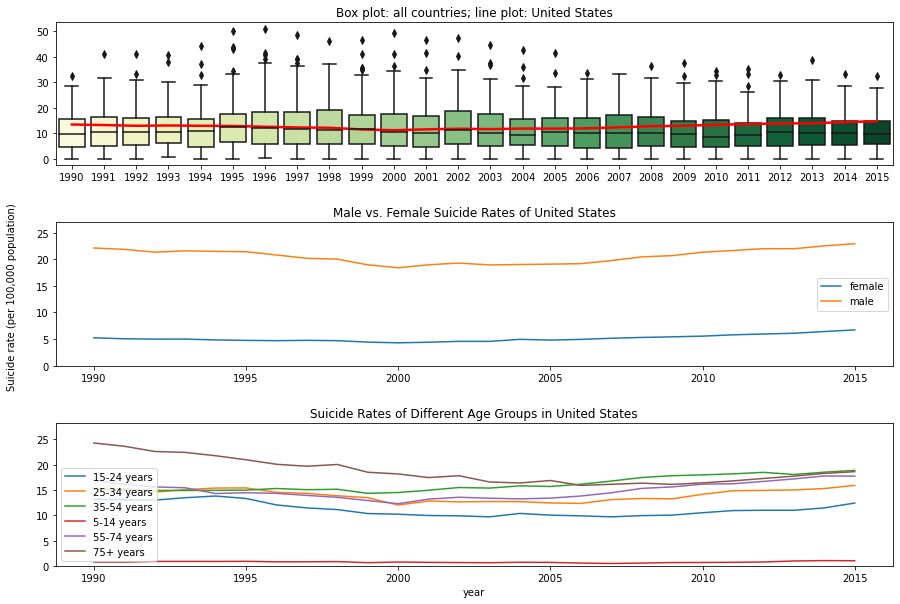

In [20]:
country_stat("United States")

> * US suicide rate (both sexes) was at around the 50th percentile in late 1990, but it has increased to 75th percentile since then.
> * **Take with a grain of salt**: There are more suicide death in males than in women, but it does NOT necessarily mean that males try to kill themselves more than females. According to [American Foundation for Suicide Prevention](http://afsp.org/suicide-statistics/), female adults attempt suicide 1.5 times more than males. Here is a [BBC article](https://www.bbc.com/future/article/20190313-why-more-men-kill-themselves-than-women) looking into the discrepancy in suicide rate between males and females.
> * What drove the decrease in the suicide rate of the seniors in 1990s? Any changes in the policy or social structure? 
> * Except for the 5-14 years group, the suicide rate for every age group is slowly increasing from 2010.

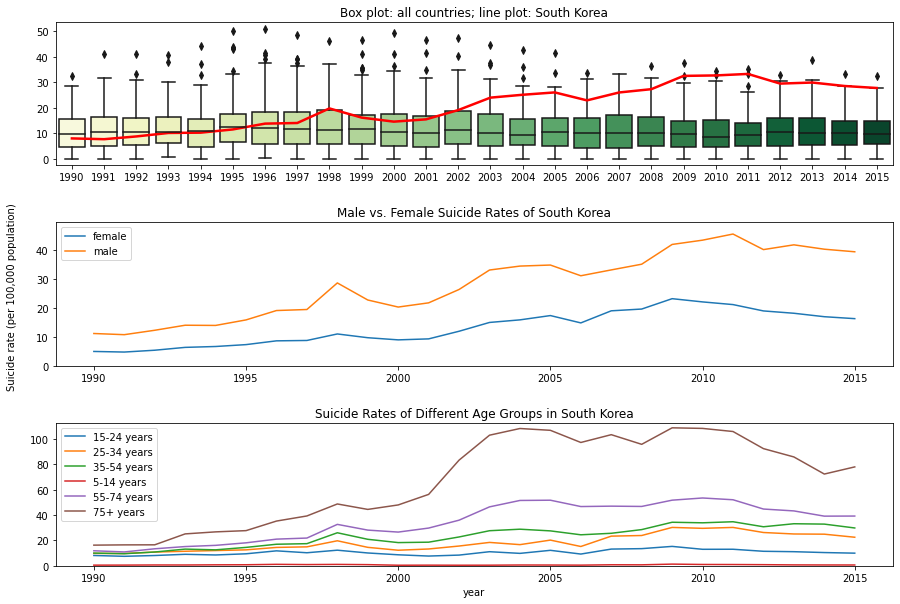

In [21]:
country_stat("South Korea")

> * It is **alarming**! South Korea was ranked below the 50th percentile in 1990, but it has become one of the top countires with the highest suicide rates since late 2000.
> * A spike in the suicide rate in 1998 coincides with the [1997 Asian finacial crisis](https://en.wikipedia.org/wiki/1997_Asian_financial_crisis), which had long-lasting effects not only on economy but also on numerous families in South Korea.
> * The suicide deaths of the 75+ years group are twice (or more) as high as those of other age groups. Is the government or other organizations doing something to address this disturbing statistics?

# Analysis by categories

## By sex

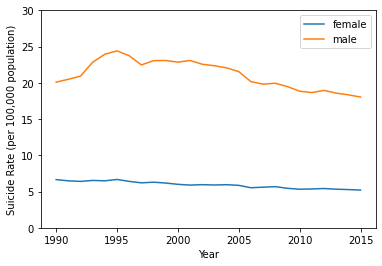

In [22]:
mf_year=main_df.groupby(["year","sex"]).agg({"suicides_no":"sum", "population":"sum"}).reset_index()
mf_year["suicides/100k pop"] = mf_year["suicides_no"]/mf_year["population"]*100000

fig, ax = plt.subplots()

for key, grp in mf_year.groupby(['sex']):
    ax.plot(grp["year"], grp["suicides/100k pop"], label=key)

plt.legend(loc='best')
plt.xlabel("Year")
plt.ylim(0,30)
plt.ylabel("Suicide Rate (per 100,000 population)")
plt.show()

> * Worldwide, males die by suicide ~4x more than females. However, as I mentioned above, suicide deaths are **different** from suicide attempts. In fact, [in US](http://afsp.org/suicide-statistics/), female adults **try** to commit suicide more than males. 
> * Female's suicide rate has stayed more or less constant, whereas male's changed. Why?
> * What could explain the difference between male and female in suicide deaths and suicide attempts? Is it something aboug their physical differences or psychological differences? Or both?

## By income groups

The [World Bank](https://datahelpdesk.worldbank.org/knowledgebase/articles/906519) puts countries into four categories based on [their GNI per income](https://data.worldbank.org/indicator/NY.GNP.PCAP.CD): low, lower-middle, upper-middle, and high. The threshold for each category is updated every year. Let's bin the countries into four income groups and check their suicide rates.

In [23]:
# Load the GNI per capita file and clean it up
gni_capita_df=pd.read_csv("../input/worldincomegroupclassification/GNI per capita.csv")
gni_df = gni_capita_df.copy()
gni_df = gni_df.iloc[4:]
n_col = gni_capita_df.iloc[3,0:4].tolist()
n_col = n_col + (gni_capita_df.iloc[3, 4:].astype("int64").tolist())
gni_df.columns = n_col
gni_df=gni_df.rename(columns={"Country Code":"country code"})

# Load the csv file containing the thresholds for the income group categorization each year
threshold_df=pd.read_csv("../input/worldincomegroupclassification/income classification threshold.csv")

# For the suicide rate dataframe, group by year and country. Add the ISO code.
s_rate_df=groupby_add_s_rate(main_df, ["year","country"])
s_rate_df=add_classification(s_rate_df, "country code")

In [24]:
# Create a list of years from 1990 to 2015. It'll be used in the following for loop.
years=s_rate_df["year"].unique().tolist()

# Add the income group and region information to the dataframe
def add_income_region(df):

    years=s_rate_df["year"].unique().tolist()
    income_group_df=pd.DataFrame()

    for year in years:

        # Add the GNI per capita column to the suicide rate dataframe
        sub_df=df[df["year"]==year]
        gni_sub_df=gni_df[[year, "country code"]]
        gni_sub_df=gni_sub_df.rename(columns={year:"GNI per capita"})
        sub_df=pd.merge(sub_df, gni_sub_df, on="country code", how="inner")
        sub_df.dropna(inplace=True)

        # bin the GNI per capita into four income groups  
        max_gni=max(sub_df["GNI per capita"])
        cut_labels_4 = ['Low', 'Lower-middle', 'Upper-middle', 'High']
        str_year=str(year)
        cut_bins = threshold_df[str_year].tolist()
        cut_bins.append(max_gni)   # WARNING: when append() is used with list, you don't need to assign it to a list (e.g., no need to have "cut_bins= at the beginning)
        sub_df["income group"]=pd.cut(sub_df["GNI per capita"], bins=cut_bins, labels=cut_labels_4)

        income_group_df=income_group_df.append(sub_df)  

    # Add the Region information to the dataframe
    region_df=class_df.reset_index().set_index("country code")["Region"]
    category_df=pd.merge(income_group_df, region_df, on="country code", how="left")
        
    return category_df

In [25]:
category_df=add_income_region(s_rate_df)
category_df

,year,country,suicides_no,population,suicides/100k pop,country code,GNI per capita,income group,Region
0,1990,Antigua and Barbuda,1,59334,1.685374,ATG,6820.0,Upper-middle,Latin America & Caribbean
1,1990,Argentina,2140,29091100,7.356202,ARG,3190.0,Upper-middle,Latin America & Caribbean
2,1990,Australia,2202,15807000,13.930537,AUS,17300.0,High,East Asia & Pacific
3,1990,Austria,1825,7231353,25.237324,AUT,20630.0,High,Europe & Central Asia
4,1990,Barbados,16,237000,6.751055,BRB,7600.0,Upper-middle,Latin America & Caribbean
...,...,...,...,...,...,...,...,...,...
1995,2015,Turkmenistan,133,4886514,2.721777,TKM,7030.0,Upper-middle,Europe & Central Asia
1996,2015,Ukraine,7574,40345446,18.772875,UKR,2700.0,Lower-middle,Europe & Central Asia
1997,2015,United Kingdom,4910,61082942,8.038251,GBR,44290.0,High,Europe & Central Asia
1998,2015,United States,44189,300078511,14.725813,USA,56740.0,High,North America


> Great! Now we have a dataframe that contains the income group and region info.

Before looking at the suicide rates of different income groups, we should see whether we have enough data points for each income group.

In [26]:
# How many countries in each category were survayed each year?
def country_counts(category):
    dist_df=category_df.groupby(["year", category]).agg({"country code":"nunique"}).reset_index()
    sns.lineplot(x='year', y='country code', data=dist_df, hue=category).set_title("Number of countries surveyed")
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

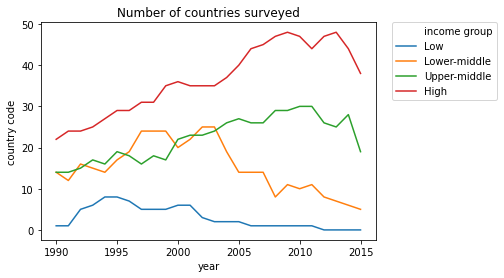

In [27]:
country_counts("income group")

> Few countries in the Low income group have been surveyed. Although I won't leave out this group from the following analysis, I will not pay attention to it since we do not have enough data points.

In [28]:
def category_and_year(category, year):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # Left plot: All the groups in the select category over time
    sns.lineplot(x = "year", y = "suicides/100k pop", data=category_df, estimator="median",
                 hue=category, ci=None, ax=ax1)
    # Add a vertical line to show where the select year is

    ymax = max(category_df.groupby(["year",category])["suicides/100k pop"].median())
    ymin = min(category_df.groupby(["year",category])["suicides/100k pop"].median())
    
    ax1.vlines(year, ymin, ymax, linestyles ="dashed", colors ="k", label=year )
    ax1.text(year+0.5, ymax-1, year, fontsize=15)
    
    # Right plot: All the groups in the select category in the chosen year
    sub_df=category_df[category_df["year"]==year]
    
    # Set the descending order for the categories of the violin plot
    inc_order = sub_df.groupby(category)["suicides/100k pop"].median().reset_index()
    inc_order = inc_order.sort_values("suicides/100k pop", ascending=False).set_index(category).index.tolist()
    
    sns.violinplot(x = category, y = "suicides/100k pop", data = sub_df, 
                   scale = 'width', inner = 'quartile', color='w', order=inc_order, ax=ax2)
    ax2.set_title("Suicide rate (per 100,000 population) in {fyr} categorized by {fcat}".format(fyr=year, fcat=category))
      
    # Rotate the x labels for regions
    if category == "Region":
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, horizontalalignment='right')

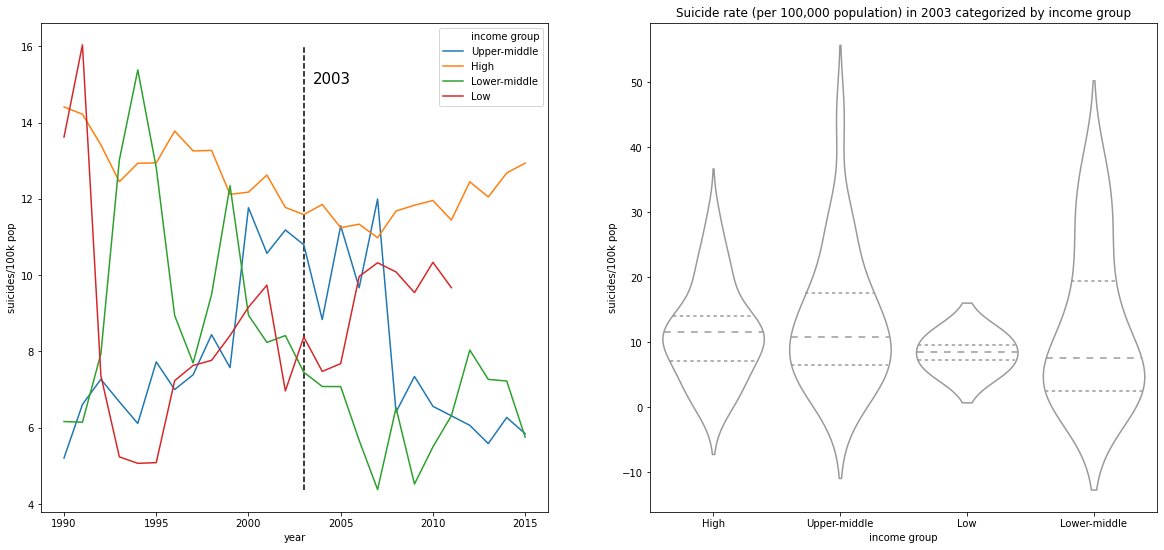

In [29]:
category_and_year("income group", 2003)

> * The suicide rate of the high income group is consistantly high, whereas other groups fluctuated.
> * **High income vs. Upper-middle income**: They are right next to each other in terms of the income group, but their suicide rates are very different especially from 2009 to 2015. Interesting.
> * We need more data points from the Low income group.
> * For further analysis, I'll focus on **the High and Upper-Middle income groups**.

## By region

Again, let's check if we have enough countries for each category to make any important implications from the analysis

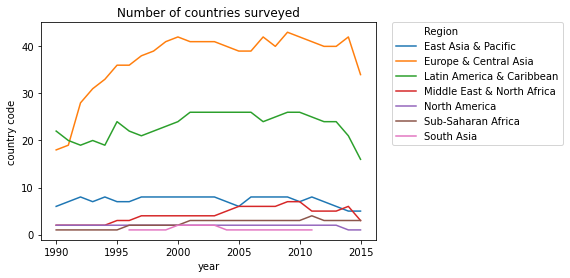

In [30]:
country_counts("Region")

> Not many countries in South Asia and Sub-Saharan Africa have been surveyed. Take this account when analyzing the data.

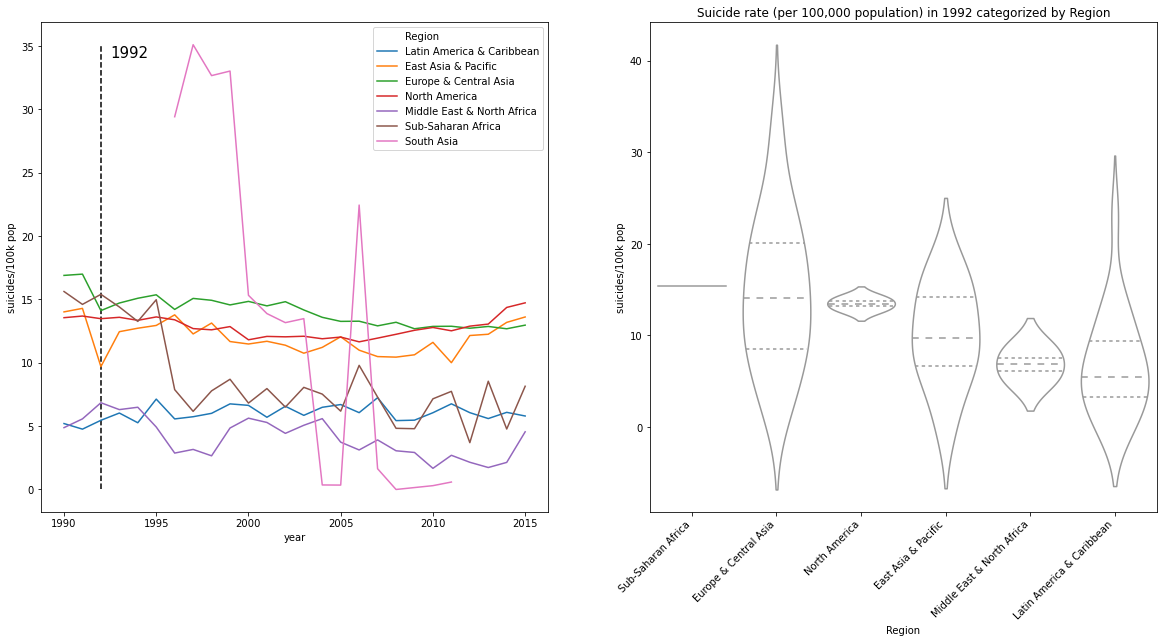

In [31]:
category_and_year("Region", 1992)

> * Latin America and Europe show consistant suicide rate thoroughout the years and we have more than 15 countires per region surveyed. Let's focus on these two groups for further analysis.
> * Geological region is not the best proxy for the culture (i.e. two countries in the same region could have very different cultures). I wonder if there is a way to group countries based on similar cultures. Could natural language processing help find similiarities in culture?

## By Age Group

IMPORTANT: For the age group, I'd like to look at **% of total suicide rate** instead of the suicide rate.

In [32]:
# Calculate % of total suicide rate for each age group
age_grp_df=groupby_add_s_rate(main_df, ["year","country-year", "age"])
total_s_rate_df=age_grp_df.groupby("country-year").agg({"suicides/100k pop":"sum"}).reset_index()
total_s_rate_df=total_s_rate_df[["country-year", "suicides/100k pop"]]
total_s_rate_df=total_s_rate_df.rename(columns={"suicides/100k pop": "total suicide rate"})

age_s_rate=pd.merge(age_grp_df, total_s_rate_df, on="country-year", how='left') 
age_s_rate["% total suicide rate"]=age_s_rate["suicides/100k pop"]/age_s_rate["total suicide rate"]*100

In [33]:
age_s_rate

,year,country-year,age,suicides_no,population,suicides/100k pop,total suicide rate,% total suicide rate
0,1990,Antigua and Barbuda1990,15-24 years,0,13425,0.000000,8.551394,0.000000
1,1990,Antigua and Barbuda1990,25-34 years,0,12109,0.000000,8.551394,0.000000
2,1990,Antigua and Barbuda1990,35-54 years,1,11694,8.551394,8.551394,100.000000
3,1990,Antigua and Barbuda1990,5-14 years,0,13488,0.000000,8.551394,0.000000
4,1990,Antigua and Barbuda1990,55-74 years,0,6608,0.000000,8.551394,0.000000
...,...,...,...,...,...,...,...,...
12319,2015,Uruguay2015,25-34 years,119,467730,25.442029,122.870297,20.706411
12320,2015,Uruguay2015,35-54 years,173,864438,20.013003,122.870297,16.287909
12321,2015,Uruguay2015,5-14 years,5,494107,1.011927,122.870297,0.823573
12322,2015,Uruguay2015,55-74 years,167,605275,27.590765,122.870297,22.455195


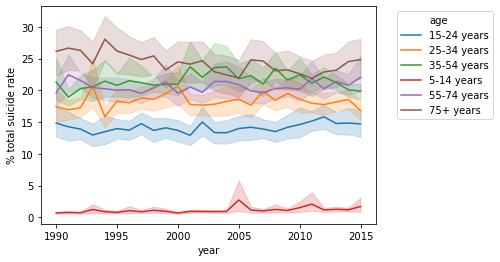

In [34]:
# Plot suicide rates of different age groups
sns.lineplot(x="year", y="% total suicide rate", data=age_s_rate, estimator="mean", hue="age")
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')

> * It appears that the suicide rate goes up as people age. It is odd when you think about [a study on happiness](https://exploringyourmind.com/middle-aged-people-happiest/), which demonstrated that middle-aged people are happiest. Is it possible that committing suicide has nothing to do with being happy/unhappy?
> * It is not surprising that 5-14 years group had the lowest suicide rate.

## Visualizing high vs. low risk groups

The analyses above indicate that 75+ year-old people, high income group countries, and Europe have relatively high suicide rates than other respective categories. On the other hand, 15-24 years, Upper-middle income, and Latin America & Caribbean have low suicide rate compared to other categories. 

Based on the EDA, I hypothesize that the suicide rate of **75+ year-old people living in high income European countries** is significantly higher than that of **15-24 years in Upper-middle income countires in Latin America or Caribbean**. 

Let's test this hypothesis!

In [35]:
# Group the suicide rate dataframe by year, country, and age. Add ISO contry code.
main_grp=groupby_add_s_rate(main_df, ["year","country","age"])
main_grp=add_classification(main_grp, "country code")

# Add the income group and region information
main_grp=add_income_region(main_grp)

In [36]:
# Add a label to indicate which group the data point falls into. 
def make_labels(df):
    if df["age"]=="75+ years" and df["income group"]=="High" and df["Region"]=="Europe & Central Asia":
        value="75+ years, high income, Europe"
    elif df["age"]=="15-24 years" and df["income group"]=="Upper-middle" and df["Region"]=="Latin America & Caribbean":
        value="15-24 years, Upper-middle income, Latin America & Caribbean"
    else:
        value="other"

    return value

In [37]:
# Add labels to each row using apply() method
main_grp["label"] = main_grp.apply(make_labels, axis=1)

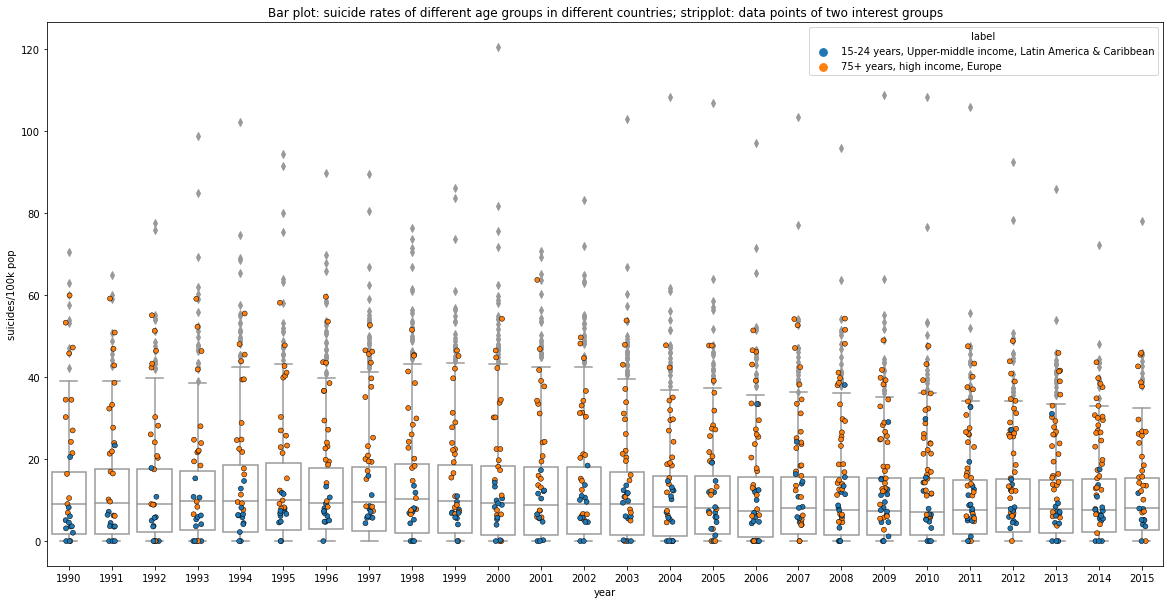

In [38]:
# Get rid of "other" data so that stripplot only shows two groups of my interest
stripplot_df=main_grp[~(main_grp["label"]=="other")]

# Create a bar plot and a strip plot
fig, ax = plt.subplots(figsize=(20,10))
plt.title("Bar plot: suicide rates of different age groups in different countries; stripplot: data points of two interest groups")
sns.boxplot(y=main_grp['suicides/100k pop'], x=main_grp['year'], color="white")
sns.stripplot(x="year", y="suicides/100k pop", hue="label", data=stripplot_df,
                   size=5,jitter=True, edgecolor="black", linewidth=0.5)

> The orange dots are distinctively separate from the blue dots. Is the difference significant? To answer this question, we should run a statistical test.

In [39]:
# Run a t-test between two groups

from scipy.stats import ttest_ind

cat1 = main_grp[main_grp['label']=="75+ years, high income, Europe"]
cat2 = main_grp[main_grp['label']=="15-24 years, Upper-middle income, Latin America & Caribbean"]

ttest_ind(cat1["suicides/100k pop"], cat2["suicides/100k pop"])


Ttest_indResult(statistic=20.614301803210235, pvalue=1.6074733609156887e-77)

> p-value is smaller than 0.05, indicating that two groups are significantly different.

# Further questions

* Before this data analysis, I didn't know and never imagined that senior's suicide rate was this high. What is pushing them to this horrible decision? Given that an aging population is one of the recent major demographic trends, there should be some in-depth studies on seniors' psychological health.
* As stated above, why do women attempt suicide more than men but their suicide death rate is lower than men's?
* Different people would think about killing themselves for different reasons. Are they different based on their socioeconomic status or their age? If yes, wouldn't we need different suicide prevention strategies for different groups?
* The data collection is biased; only a few countries in South Asia and Sub-Saharan Africa were surveyed for the suicide rate. The dataset also lacks the data from low-income countries. What do global organizations do to reach out to countries with weak infrastructure for data collection?
* What are some effective suicide prevention programs? Are they effective universally? Or should they be tailored to a country/culture?

### Thanks for reading my kernel. As I'm learning a lot from fellow Kagglers' work, I hope mine gave you some insights.